In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import splrep, splev
from scipy.stats import  expon, uniform, kstest, rv_continuous, ks_2samp, cramervonmises_2samp, wasserstein_distance
from typing import Callable
import pandas as pd
from collections import defaultdict
from random import choices

Define a watershed function (stand-in for running HMS).  This converts precipitation to discharge.

In [2]:
y = [6000, 7000, 5500, 8000, 4000, 3000, 3500, 2500, 4000, 2000, 1000, 500, 1000]  # Unit discharge
n = len(y)
x = np.linspace(0, 100, n)  # watershed spatial component
tck = splrep(x, y)
watershed = lambda x: splev(x, tck, ext=1)

Text(0, 0.5, 'Unit Discharge (cfs/in)')

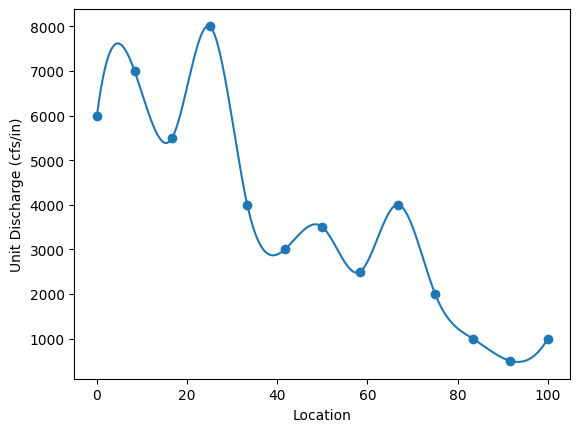

In [3]:
fig, ax = plt.subplots()
ax.scatter(x, y)
xfit = np.linspace(0, 100, 1000)
yfit = watershed(xfit)
ax.plot(xfit, yfit)
ax.set_xlabel("Location")
ax.set_ylabel("Unit Discharge (cfs/in)")

Define hydrologic region model

In [4]:
precip = expon
locs = uniform(0, 1000)

Approximate long-term flood series

In [5]:
n = 10000
p = precip.rvs(size=n)
l = locs.rvs(size=n)
qs = p * splev(l, tck, ext=1)
qs = qs[qs > 0]

Text(0, 0.5, 'Cumulative Probability')

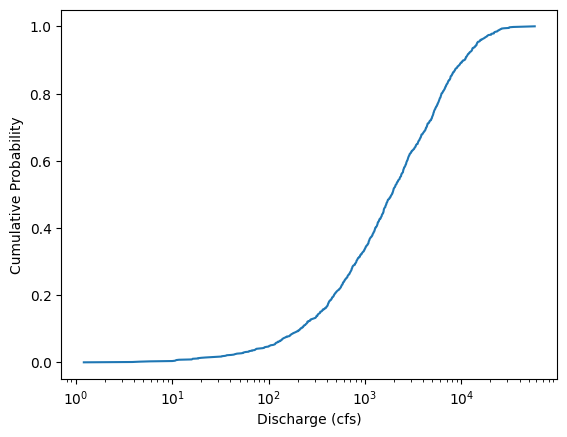

In [6]:
fig, ax = plt.subplots()
q_sort = np.sort(qs)
ratio = np.linspace(0, 1, len(q_sort))
ax.plot(q_sort, ratio)
ax.set_xscale("log")
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Cumulative Probability")

SST

In [7]:
def sst(storm_catalog: list, spatial_sampler: rv_continuous, watershed_function: Callable) -> list:
    new_locs = spatial_sampler.rvs(size=len(storm_catalog))
    qs = storm_catalog * watershed_function(new_locs)
    return qs[qs > 0]

Subset to observed record

In [26]:
n_obs = 10
p_obs = p[:n_obs]
p_obs = choices(p, k=n_obs)

SST

In [ ]:
epochs = 100
sst_qs = []
spatial_sampler = uniform(0, 1000)
for e in range(epochs):
    sst_qs.extend(sst(p_obs, spatial_sampler, watershed))


benchmark

1.020312995280793e-05
1.020312995280793e-05
1.020312995280793e-05


Text(0, 0.5, 'Cumulative Probability')

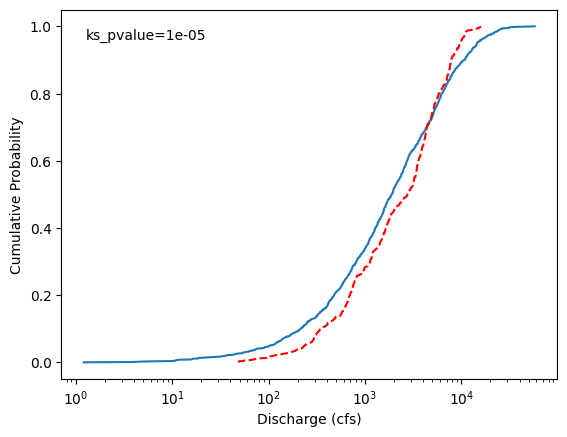

In [28]:
ks = kstest(sst_qs, qs)
print(ks.pvalue)

ks = ks_2samp(sst_qs, qs)
print(ks.pvalue)

ks = ks_2samp(np.log(sst_qs), np.log(qs))
print(ks.pvalue)

fig, ax = plt.subplots()
# Original data
q_sort = np.sort(qs)
ratio = np.linspace(0, 1, len(q_sort))
ax.plot(q_sort, ratio)
# SST data
sst_qs_sort = np.sort(sst_qs)
ratio = np.linspace(0, 1, len(sst_qs_sort))
ax.plot(sst_qs_sort, ratio, color="r", ls="dashed")
# KS Pvalue
ax.text(0.05, 0.95, f'ks_pvalue={round(ks.pvalue, 5)}', ha='left', va='top', transform = ax.transAxes)
# Format
ax.set_xscale("log")
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Cumulative Probability")

Plot convergence of different spatial samplers.  X axis is years of record.  y axis is KS test.  groups are sampler.

In [59]:
def sst_ks_test(spatial_sampler: rv_continuous, p_obs: list, target: list, epochs: int = 50) -> float:
    # sst_qs = []

    # for e in range(epochs):
    #     sst_qs.extend(sst(p_obs, spatial_sampler, watershed))
    p_series = np.repeat(p_obs, epochs)
    sst_qs = sst(p_series, spatial_sampler, watershed)
    sst_qs.sort()
    target.sort()
    # stat = cramervonmises_2samp(sst_qs, target).pvalue
    stat = wasserstein_distance(sst_qs, target)
    return stat, sst_qs

In [45]:
def benchmark_convergence(record_lengths: list, spatial_sampler: rv_continuous, p: list, target: list, samples: int = 100, epochs: int = 100) -> pd.DataFrame:
    data = defaultdict(list)
    all_qs = []
    for n in range(samples):
        for r in record_lengths:
            record = choices(p, k=r)
            ks, qs = sst_ks_test(spatial_sampler, record, target, epochs)
            all_qs.append(qs)
            data["record_length"].append(r)
            data["ks_test_pvalue"].append(ks)
    df = pd.DataFrame.from_dict(data)

    diagnostic_plot(target, all_qs, spatial_sampler.dist.name, data["ks_test_pvalue"])
    return df

def diagnostic_plot(target, all_qs, name, ks_vals):
    # Plot diagnostic
    fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
    # Original data
    target = np.sort(target)
    ratio = np.linspace(0, 1, len(target))
    axs[0].plot(target, ratio, zorder=1)
    # SST data
    for q in all_qs:
        q = np.sort(q)
        ratio = np.linspace(0, 1, len(q))
        axs[0].plot(q, ratio, color="r", alpha=0.1, zorder=0)
    # Format
    axs[0].set_xscale("log")
    axs[0].set_xlabel("Discharge (cfs)")
    axs[0].set_ylabel("Cumulative Probability")

    # ks vals
    axs[1].hist(ks_vals)
    axs[1].set_xlabel("Ks test stat")
    axs[1].set_ylabel("Pr(x)")
    fig.savefig(f"{name}.png")


In [63]:
def compare_samplers(samples: int, epochs: int):
    samplers = [
        {"sampler": uniform(0, 1000), "id": "naive"},
        {"sampler": uniform(0, 100), "id": "optimized"},
        {"sampler": uniform(0, 50), "id": "overly-constrained"}
    ]

    all_data = []
    record_lengths = [10000, 1000, 100, 10]
    for ss in samplers:
        df = benchmark_convergence(record_lengths, ss["sampler"], p, qs, samples, epochs)
        df["sampler"] = ss["id"]
        all_data.append(df)
    return pd.concat(all_data).reset_index()

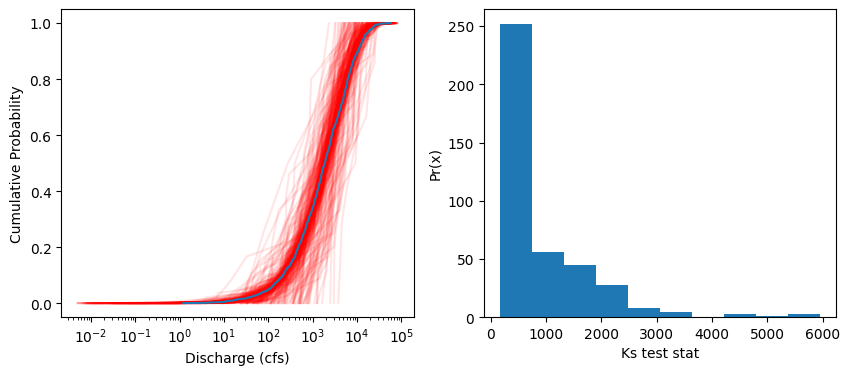

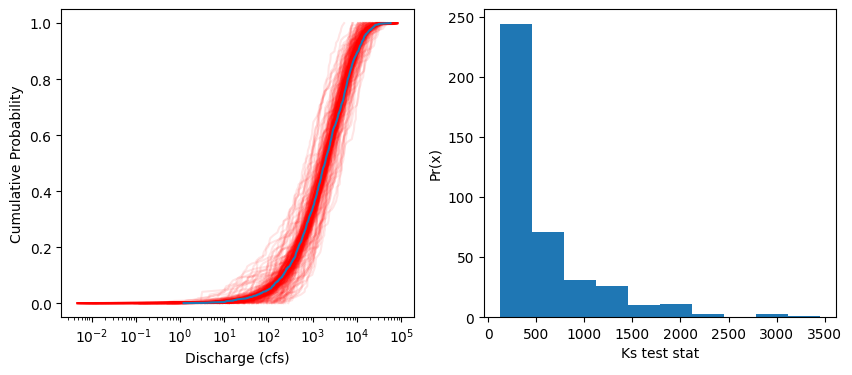

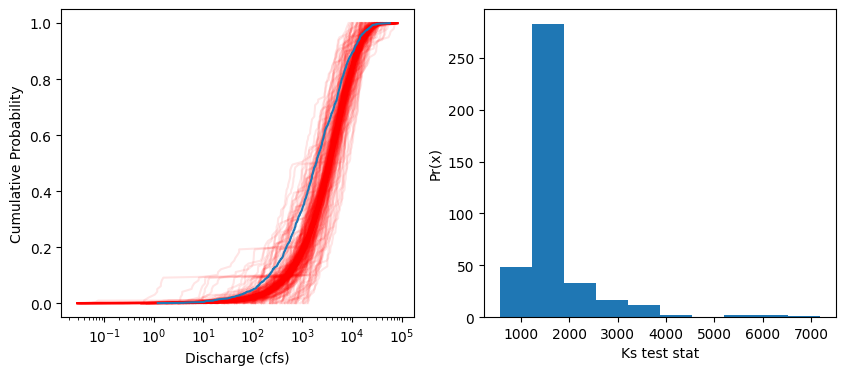

In [64]:
df = compare_samplers(samples=100, epochs=10)
# df.describe()

<Axes: xlabel='record_length', ylabel='ks_test_pvalue'>

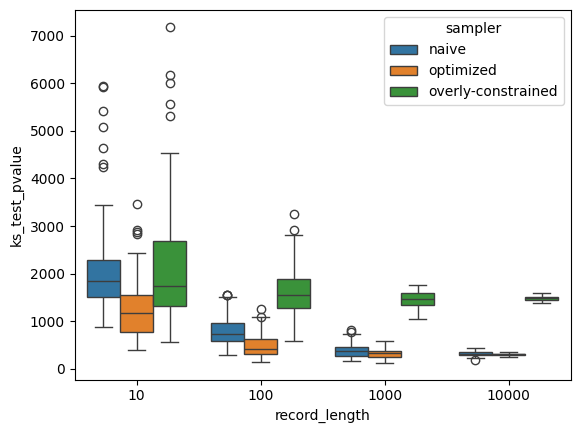

In [65]:


fig, ax = plt.subplots()
sns.boxplot(df, x="record_length", y="ks_test_pvalue", hue="sampler", ax=ax)